# **GCN for Textual Dataset**

### *Learning semantic representations through multimodal graph neural networks*

**References**

https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d

https://tkipf.github.io/graph-convolutional-networks/

https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8

**API**

https://pytorch.org/docs/stable/nn.functional.html

https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html

https://github.com/rusty1s/pytorch_geometric

## **Install packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/TFG/Code/MyModel'

Mounted at /content/drive
/content/drive/My Drive/TFG/Code/MyModel


In [ ]:
import torch
import torch.nn.functional as F
print(torch.__version__)

import numpy as np
import matplotlib.pyplot as plt
import time

from numpy import dot
from numpy.linalg import norm
from joblib import parallel_backend
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
plt.style.use('ggplot')

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

1.8.1+cu101
     |████████████████████████████████| 2.6MB 11.7MB/s 
     |████████████████████████████████| 1.5MB 10.6MB/s 
     |████████████████████████████████| 1.0MB 11.2MB/s 
     |████████████████████████████████| 389kB 10.3MB/s 
     |████████████████████████████████| 215kB 15.3MB/s 
     |████████████████████████████████| 235kB 22.5MB/s 
     |████████████████████████████████| 2.2MB 29.4MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 


## **Import Textual Features**

In [ ]:
#TEXTUAL_DATA = np.load('0_textual_features_439.npy')
TEXTUAL_DATA = np.load('Textual_att_matrix_short.npy')
TEXTUAL_DATA = TEXTUAL_DATA.astype('f')

print('Textual Attributes')
print(f'Shape of dataset: {TEXTUAL_DATA.shape}')
print(TEXTUAL_DATA.dtype)

Textual Attributes
Shape of dataset: (439, 2362)
float32


In [ ]:
# # Normalize textual dataset
# scaler = StandardScaler()
# TEXTUAL_DATA = scaler.fit_transform(TEXTUAL_DATA)

## **1. Compute Similarity Matrix**

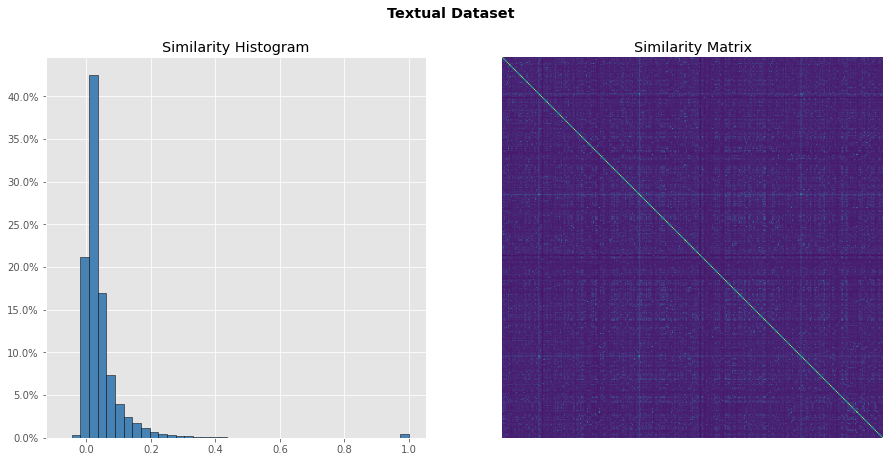

1.853 seconds


In [ ]:
# Similarity Matrix 

start_time = time.time()

# Create cosine similarity histogram
HISTOGRAM = []
a = 1

with parallel_backend('multiprocessing', n_jobs=-1):
    for i in range(len(TEXTUAL_DATA)):
        HISTOGRAM.append(1)
        for j in range(a,len(TEXTUAL_DATA)): 
            # Compute cosine similarity
            cos_sim = dot(TEXTUAL_DATA[i], TEXTUAL_DATA[j])/(norm(TEXTUAL_DATA[i])*norm(TEXTUAL_DATA[j]))
            HISTOGRAM.append(cos_sim)
        a = a + 1
        if i % 250 == 0:     
            print(f'{i} of {len(TEXTUAL_DATA)}')
            
# Create cosine similarity matrix
SIMILARITY_MATRIX = np.empty((len(TEXTUAL_DATA),len(TEXTUAL_DATA)))

upper = np.triu_indices(len(TEXTUAL_DATA)) # Find upper right indices
lower = np.tril_indices(len(TEXTUAL_DATA), -1) # Find lower left indices
SIMILARITY_MATRIX[upper] = HISTOGRAM # Assign list values to upper right matrix
SIMILARITY_MATRIX[lower] = SIMILARITY_MATRIX.T[lower] # Make the matrix symmetric

clear_output()

# Plot the cosine similarity histogram and matrix
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

ax[0].hist(HISTOGRAM, weights=np.ones(len(HISTOGRAM))/len(HISTOGRAM), bins=40, color='steelblue', edgecolor='black')
ax[0].set_title('Similarity Histogram')
ax[0].yaxis.set_major_formatter(PercentFormatter(1))

ax[1].imshow(SIMILARITY_MATRIX)
ax[1].set_title('Similarity Matrix')
ax[1].set_axis_off()

fig.suptitle('Textual Dataset', fontsize='x-large', fontweight='bold')
plt.show()

print(f'{(time.time() - start_time):.3f} seconds')

## **2. Determine Adjacency Matrix** 

In [ ]:
# Computes graph edges 

# Create source and target list
SOURCE = []
TARGET = []

for x in range(len(TEXTUAL_DATA)):
    for y in range(len(TEXTUAL_DATA)): 
        if x != y:
            # Define optimal cosine similarity
            if SIMILARITY_MATRIX[x,y] > 0.1:
                SOURCE.append(x)
                TARGET.append(y)

SOURCE = np.array(SOURCE)
TARGET = np.array(TARGET)

# Create the graph connectivity
edge_index = torch.tensor([SOURCE,TARGET], dtype=torch.long)

In [ ]:
# # Save textual edges index
# TEXTUAL_EDGES = edge_index.detach().cpu().numpy()
# np.save('textual_edges.npy', TEXTUAL_EDGES)

In [ ]:
# # Import visual edges index
# VISUAL_EDGES = np.load('visual_edges.npy')
# edge_index = torch.tensor(VISUAL_EDGES, dtype=torch.long)

## **3. Create Textual Graph**

In [ ]:
# Convert array to tensor
xT = torch.tensor(list(TEXTUAL_DATA), dtype=torch.float)
y = torch.tensor(list(range(len(TEXTUAL_DATA))), dtype=torch.long)

# Create dataset
dataset = Data(x=xT, edge_index=edge_index, y=y)

# All dataset is training
dataset.train_mask = torch.tensor(list([True] * len(TEXTUAL_DATA)), dtype=torch.bool)

data = dataset

print(dataset)
print('====================================================================')
# Gather some statistics about the graph.
print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of edges: {dataset.num_edges}')
print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

Data(edge_index=[2, 17988], train_mask=[439], x=[439, 2362], y=[439])
Number of nodes: 439
Number of edges: 17988
Number of features: 2362


## **4. Define GCN Layer**

In [ ]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjency matrix
        # In every layer we want to aggregate all the neighboring nodes but also the node itself
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix
        # Multiply the embeddings with our weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]
        # Normalize node features
        return norm.view(-1, 1) * x_j

## **5. Define Graph Net**

In [ ]:
class Net(torch.nn.Module):
    #def __init__(self):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 100)
        self.conv2 = GCNConv(100, len(data.y))

    #def forward(self, x, edge_index):
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = Net(dataset)
print(model)

## **6. Model Training**

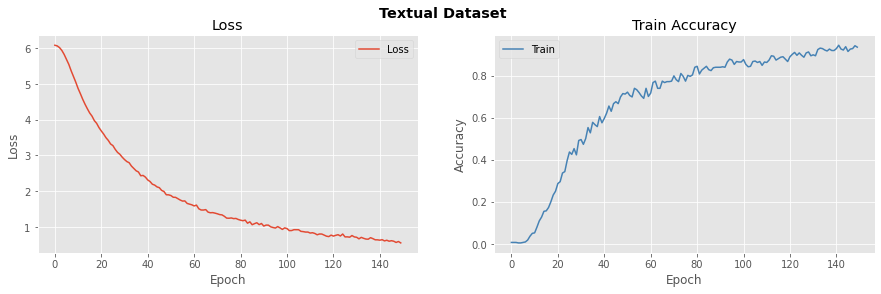

Epoch: 149
Loss: 0.55136
Train Accuracy: 0.93622
Output shape: [439, 439]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset).to(device)
data = dataset.to(device)

# Define loss function
criterion = F.cross_entropy
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out  = model(data)  # Perform a single forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes
    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients
    return loss, out

def test(data, train=True):
    model.eval()
    correct = 0
    pred = model(data).max(dim=1)[1]
    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))

train_accuracies = list()
loss_list = list()

for epoch in range(150):
    loss, out = train()
    loss_list.append(loss)

    train_acc = test(data)
    train_accuracies.append(train_acc)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Train Acc: {train_acc:.5f}')

clear_output()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].plot(loss_list, label="Loss")
ax[0].set_title('Loss')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend(loc='upper right')

ax[1].plot(train_accuracies, color='steelblue', label="Train")
ax[1].set_title('Train Accuracy')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend(loc='upper left')

fig.suptitle('Textual Dataset', fontsize='x-large', fontweight='bold')
plt.show()

print(f'Epoch: {epoch}') 
print(f'Loss: {loss:.5f}') 
print(f'Train Accuracy: {train_acc:.5f}')
print(f'Output shape: {list(out.shape)}')

## **7. Export Textual Embeddings**

In [ ]:
TEXTUAL_EMBEDDINGS = model.conv1(data.x, data.edge_index)
print(f'Embedding shape: {TEXTUAL_EMBEDDINGS.shape}')

Embedding shape: torch.Size([439, 100])


In [ ]:
# Convert tensor to Numpy Array
TE = TEXTUAL_EMBEDDINGS.detach().cpu().numpy()

# Export the textual embeddings after training
np.save('Textual_Embeddings.npy', TE)
print('Textual embeddings finished!')

Textual embeddings finished!
